<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/master/notebooks/languageXplay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip -q install pybullet wandb

     |████████████████████████████████| 76.6MB 70kB/s 
     |████████████████████████████████| 1.9MB 67.3MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 133kB 63.7MB/s 
     |████████████████████████████████| 102kB 14.2MB/s 
     |████████████████████████████████| 163kB 56.9MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 


In [1]:
from pathlib import Path
import os
import requests
import json
import pprint
import logging

In [2]:
pp = pprint.PrettyPrinter(indent=4)

with open('../config/local_config_gcs.json') as f:
    config = json.load(f)
    print('Config:')
    pp.pprint(config)

Config:
{   'batch_size': 32,
    'colab': False,
    'data_source': 'GCS',
    'device': 'CPU',
    'from_tfrecords': True,
    'gcbc': False,
    'latent_dim': 8,
    'layer_size': 64,
    'learning_rate': 0.0003,
    'num_distribs': None,
    'qbits': None,
    'test_datasets': ['UR5_slow_gripper_test'],
    'train_datasets': ['UR5']}


In [3]:
#@title Workpace Setup (Local vs Colab)

if config['colab']:
    from google.colab import drive, auth
    print('Using colab setup')
    try:
        !git clone 'https://github.com/sholtodouglas/learning_from_play'
    except: 
        pass
    WORKING_PATH = Path('/content/learning_from_play')
    drive.mount('/content/drive')
    os.chdir(WORKING_PATH)
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
    print(f'Storage path: {STORAGE_PATH}')
else:
    print('Using local setup')
    WORKING_PATH = Path().absolute().parent
    print(f'Working path: {WORKING_PATH}')
    os.chdir(WORKING_PATH)
    STORAGE_PATH = WORKING_PATH
    print(f'Storage path: {STORAGE_PATH}')
    
import lfp
    
if config['data_source'] == 'DRIVE':
    print('Reading data from Google Drive')
    TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in config['train_datasets']]
    TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in config['test_datasets']]
elif config['data_source'] == 'GCS':
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    if region != 'Iowa':
        logging.warning(f'You are accessing GCS data from {region}, outside of Iowa region')
    project_id = 'learning-from-play-303306'
    bucket_name = 'lfp_iowa_bucket'
    if config['colab']:
        auth.authenticate_user()
    TRAIN_DATA_PATHS = lfp.data.get_tf_records(config['train_datasets'], bucket_name)
    TEST_DATA_PATHS = lfp.data.get_tf_records(config['test_datasets'], bucket_name)
else:
    print('Reading data from local filesystem')
    TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in config['train_datasets']]
    TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in config['test_datasets']]

Using local setup
Working path: /Users/Tristan/Documents/Robotic Learning/learning_from_play
Storage path: /Users/Tristan/Documents/Robotic Learning/learning_from_play
Reading data from Google Cloud Storage


PermissionDeniedError: Error executing an HTTP request: HTTP response code 401 with body '{
  "error": {
    "code": 401,
    "message": "Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket.",
    "errors": [
      {
        "message": "Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket.",
        "domain": "global",
        "reason": "required",
        "locationType": "header",
        "location": "Authorization"
      }
    ]
  }
}
'
	 when reading gs://lfp_iowa_bucket/data/UR5/tf_records

# Data Creation

In [3]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

if config['device'] == 'TPU':
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    NUM_DEVICES = strategy.num_replicas_in_sync
    print("REPLICAS: ", NUM_DEVICES)
else:
    physical_devices = tf.config.list_physical_devices()
    if config['device'] == 'GPU':
        tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
    NUM_DEVICES = 1
    print(physical_devices)

Tensorflow version 2.4.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Dataset

In [4]:
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
from collections import Counter
import random
import datetime

import lfp
from natsort import natsorted

In [5]:
# Use this to edit modules without needing to restart the kernel
import importlib
importlib.reload(lfp.data)
importlib.reload(lfp.model)
importlib.reload(lfp.train)


<module 'lfp.train' from '/Users/Tristan/Documents/Robotic Learning/learning_from_play/lfp/train.py'>

### Config Flags

In [6]:
GLOBAL_BATCH_SIZE = config['batch_size'] * NUM_DEVICES
dl = lfp.data.PlayDataloader(batch_size=GLOBAL_BATCH_SIZE)

In [7]:
# Train data
# Hey Tristan, I got everything else but I'm a bit tired and want an elegant way to do this
# basically I have a function which gets the tf record paths in GCS (you'll see it at the top of data)
# but too tired to work out how to get that elegantly into the flow with the option of local files, don't want to get too fucked with ifs
train_data = dl.extract(TRAIN_DATA_PATHS, from_tfrecords=config['from_tfrecords'])
train_dataset = dl.load(train_data)

TypeError: argument of type 'PosixPath' is not iterable

In [20]:
# Validation data
valid_data = dl.extract(TEST_DATA_PATHS, from_tfrecords=from_tfrecords)
valid_dataset = dl.load(valid_data)

{   'acts': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(256, None), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(256, 50, None), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(256, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(256,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(256, None), dtype=tf.int32, name=None)}


In [21]:
train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))

In [ ]:
%%time
for i in range(0,10):
  train_dist_dataset.next()


# Model

# Training Loop

In [83]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar
import tensorflow_addons as tfa
import tensorflow_probability as tfp
tfd = tfp.distributions

import time
import io
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [84]:
from lfp.metric import MaxMetric, create_metrics, record, log_action_breakdown
from lfp.train import LFPTrainer

In [85]:
def train_setup():
    model_params = {'obs_dim':dl.obs_dim,
                'goal_dim':dl.goal_dim,
                'act_dim':dl.act_dim,
                'layer_size':config['layer_size'], 
                'latent_dim':config['latent_dim']}
    
    actor = lfp.model.create_actor(**model_params, gcbc=config['gcbc'], num_distribs=config['num_distribs'])

    if config['gcbc']:
        encoder = None
        planner = None
    else:
        encoder = lfp.model.create_encoder(**model_params)
        planner = lfp.model.create_planner(**model_params)

    optimizer = tf.optimizers.Adam(learning_rate=config['learning_rate'])
    trainable_variables = actor.trainable_variables + encoder.trainable_variables + planner.trainable_variables
    return actor, encoder, planner, optimizer, trainable_variables

if config['device']=='CPU':
    actor, encoder, planner, optimizer, trainable_variables = train_setup()
else:
    with strategy.scope():
        actor, encoder, planner, optimizer, trainable_variables = train_setup()
        
train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))

In [86]:
with strategy.scope():
    nll_action_loss = lambda y, p_y: tf.reduce_sum(-p_y.log_prob(y), axis=2)
    mae_action_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
    mse_action_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

    def compute_loss(labels, predictions, mask, seq_lens, weightings=None):
        if config['num_distribs'] is not None:
            per_example_loss = nll_action_loss(labels, predictions) * mask
        else:
            per_example_loss = mae_action_loss(labels, predictions) * mask

        per_example_loss = tf.reduce_sum(per_example_loss, axis=1) / seq_lens  # take mean along the timestep
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)


    def compute_MAE(labels, predictions, mask, seq_lens, weightings=None):
        per_example_loss = mae_action_loss(labels, predictions) * mask
        per_example_loss = tf.reduce_sum(per_example_loss, axis=1) / seq_lens  # take mean along the timestep
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)


    def compute_regularisation_loss(plan, encoding):
        # Reverse KL(enc|plan): we want planner to map to encoder (weighted by encoder)
        reg_loss = tfd.kl_divergence(encoding, plan)  # + KL(plan, encoding)
        return tf.nn.compute_average_loss(reg_loss, global_batch_size=GLOBAL_BATCH_SIZE)

    train_loss, valid_loss, actor_grad_norm, encoder_grad_norm, planner_grad_norm, \
    actor_grad_norm_clipped, encoder_grad_norm_clipped, planner_grad_norm_clipped, global_grad_norm, \
    test, test2,  train_act_with_enc_loss, train_act_with_plan_loss, valid_act_with_enc_loss, valid_act_with_plan_loss,\
    train_reg_loss, valid_reg_loss, valid_position_loss,  valid_max_position_loss, valid_rotation_loss, valid_max_rotation_loss, valid_gripper_loss = create_metrics()


# Now outside strategy .scope
def train_step(inputs, beta, prev_global_grad_norm):
    with tf.GradientTape() as actor_tape, tf.GradientTape() as encoder_tape, tf.GradientTape() as planner_tape:  # separate tapes to simplify grad_norm logging and clipping for stability
        # Todo: figure out mask and seq_lens for new dataset 
        states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], \
                                                 inputs['masks']

        if config['gcbc']:
            distrib = actor([states, goals])
            loss = compute_loss(actions, distrib, mask, seq_lens)
            gradients = tape.gradient(loss, actor.trainable_variables)
            optimizer.apply_gradients(zip(gradients, actor.trainable_variables))
        else:
            encoding = encoder([states, actions])
            plan = planner([states[:, 0, :], goals[:, 0,:]])  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
            z_enc = encoding.sample()
            z_plan = plan.sample()
            z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, dl.window_size, 1))
            z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, dl.window_size, 1))

            enc_policy = actor([states, z_enc_tiled, goals])
            plan_policy = actor([states, z_plan_tiled, goals])

            act_enc_loss = record(compute_loss(actions, enc_policy, mask, seq_lens), train_act_with_enc_loss)
            act_plan_loss = record(compute_loss(actions, plan_policy, mask, seq_lens), train_act_with_plan_loss)
            reg_loss = record(compute_regularisation_loss(plan, encoding), train_reg_loss)
            loss = act_enc_loss + reg_loss * beta

            actor_gradients = actor_tape.gradient(loss, actor.trainable_variables)
            encoder_gradients = encoder_tape.gradient(loss, encoder.trainable_variables)
            planner_gradients = planner_tape.gradient(loss, planner.trainable_variables)

            actor_norm = record(tf.linalg.global_norm(actor_gradients), actor_grad_norm)
            encoder_norm = record(tf.linalg.global_norm(encoder_gradients), encoder_grad_norm)
            planner_norm = record(tf.linalg.global_norm(planner_gradients), planner_grad_norm)

            gradients = actor_gradients + encoder_gradients+planner_gradients

            # if the gradient norm is more than 3x the previous one, clip it to the previous norm for stability
            gradients = tf.cond(tf.linalg.global_norm(gradients) > 3 * prev_global_grad_norm,
                                lambda: tf.clip_by_global_norm(gradients, prev_global_grad_norm)[0],
                                lambda: gradients)  # must get[0] as it returns new norm as [1]


            actor_norm_clipped = record(tf.linalg.global_norm(actor_gradients), actor_grad_norm_clipped)
            encoder_norm_clipped = record(tf.linalg.global_norm(encoder_gradients), encoder_grad_norm_clipped)
            planner_norm_clipped = record(tf.linalg.global_norm(planner_gradients), planner_grad_norm_clipped)

            record(tf.linalg.global_norm(gradients), global_grad_norm)

            optimizer.apply_gradients(zip(gradients,
                                          actor.trainable_variables + encoder.trainable_variables + planner.trainable_variables))


    return record(loss, train_loss)


def test_step(inputs, beta):
    states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], inputs['masks']

    if  config['gcbc']:
        policy = actor([states, goals], training=False)
        loss = compute_loss(actions, policy, mask, seq_lens)
        log_action_breakdown(policy, actions, mask, seq_lens, config, dl.quaternion_act, valid_position_loss, valid_max_position_loss, \
                             valid_rotation_loss, valid_max_rotation_loss, valid_gripper_loss, compute_MAE)
    else:
        encoding = encoder([states, actions])
        plan = planner([states[:, 0, :], goals[:, 0,:]])  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
        z_enc = encoding.sample()
        z_plan = plan.sample()
        z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, dl.window_size, 1))
        z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, dl.window_size, 1))
        enc_policy = actor([states, z_enc_tiled, goals])
        plan_policy = actor([states, z_plan_tiled, goals])
        act_enc_loss = record(compute_loss(actions, enc_policy, mask, seq_lens), valid_act_with_enc_loss)
        act_plan_loss = record(compute_loss(actions, plan_policy, mask, seq_lens), valid_act_with_plan_loss)
        reg_loss = record(compute_regularisation_loss(plan, encoding), valid_reg_loss)
        loss = act_plan_loss + reg_loss * beta


        log_action_breakdown(plan_policy, actions, mask, seq_lens, config, dl.quaternion_act, valid_position_loss, \
                             valid_max_position_loss, valid_rotation_loss, valid_max_rotation_loss, valid_gripper_loss, compute_MAE)


    if config['gcbc']:
        return record(loss, valid_loss)
    else:
        return record(loss,valid_loss), z_enc, z_plan


@tf.function
def distributed_train_step(dataset_inputs, beta, prev_global_grad_norm):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs, beta, prev_global_grad_norm))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)


@tf.function
def distributed_test_step(dataset_inputs, beta):
    if config['gcbc']:
        per_replica_losses = strategy.run(test_step, args=(dataset_inputs, beta))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)
    else:
        per_replica_losses, ze, zp = strategy.run(test_step, args=(dataset_inputs, beta))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None), ze.values[0], zp.values[0]

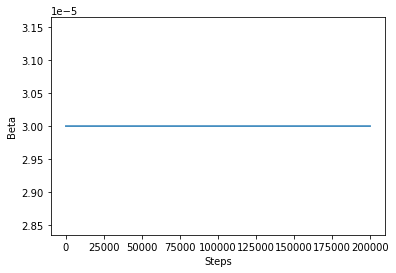

In [87]:
from lfp.train import BetaScheduler

TRAIN_STEPS = 200000
# 0.00001 so far works best for MAE - try lower - 0.00003 with a BETA accel of 10 so far works best, perfect encoder, nicely mapped planner
# recall 0.01 worked okay for probabilistic - proba still too unstable!
beta_sched = BetaScheduler('linear', 
                           beta=0.00003, 
                           beta_max=0.00003, 
                           max_steps=TRAIN_STEPS, 
                           cycles=90, 
                           duty_cycle=0.5
                           )

In [88]:
progbar = Progbar(TRAIN_STEPS, verbose=1, interval=0.5)
best_valid_loss = np.float('inf')

valid_inc = 20
save_inc = 1000

prev_grad_norm = np.float('inf')

In [89]:
from lfp.utils import save_weights, load_weights, load_optimizer_state

In [90]:
RESUME = True

In [91]:
run_name = "Tests"#"ALLB0.00003"
model_path = f'/content/drive/My Drive/Robotic Learning/LMP_test/{run_name}/'

if RESUME:
  run_id = str(np.load(model_path+'hyper_params.npz')['run_id'])
  wandb.init(project="learning-from-play_v2", id='12621l2h',  resume="must")
  load_weights(model_path, actor, encoder, planner)
  load_optimizer_state(optimizer, model_path, strategy, trainable_variables)
  print('Loaded model weights and optimiser state')
  t = wandb.run.step + valid_inc
else:
  wandb.init(project="learning-from-play_v2")
  wandb.run.name = run_name
  t = 0


planner_grad_norm_clipped,6e-05
valid_act_with_enc_loss_result,0.01849
valid_max_rotation_loss_result,5.06414
train_reg_loss_result,7.68261
encoder_grad_norm_clipped,0.00771
_runtime,279140
beta_result,3e-05
train_loss_result,0.01905
valid_rotation_loss_result,0.03184
train_act_with_plan_loss_result,0.02907
_step,125000


train_loss_result,█▄▁
valid_loss_result,█▅▁
valid_position_loss_result,█▄▁
valid_max_position_loss_result,█▁▃
valid_rotation_loss_result,█▄▁
valid_max_rotation_loss_result,█▂▁
valid_gripper_loss_result,▁█▇
actor_grad_norm,█▃▁
actor_grad_norm_clipped,█▃▁
train_act_with_enc_loss_result,█▄▁
train_act_with_plan_loss_result,█▅▁


Loaded model weights and optimiser state


In [92]:
# config = wandb.config

# # Hparams
# config.DEVICE = DEVICE
# config.WINDOW_SIZE = dl.window_size
# config.WINDOW_SHIFT = dl.window_shift
# config.LAYER_SIZE = LAYER_SIZE
# config.LATENT_DIM = LATENT_DIM
# config.GRIPPER_WEIGHT = GRIPPER_WEIGHT
# config.TRAIN_STEPS = TRAIN_STEPS
# config.beta_schedule = beta_sched.schedule
# config.beta_min = beta_sched.beta_min
# config.beta_max = beta_sched.beta_max
# config.PROBABILISTIC = PROBABILISTIC
# config.PROPRIOCEPTION = dl.proprioception
importlib.reload(lfp.utils)

<module 'lfp.utils' from '/content/learning_from_play/lfp/utils.py'>

In [93]:
from lfp.plotting import produce_cluster_fig, project_enc_and_plan, plot_to_image
from lfp.metric import log
v_it = iter(valid_dataset) #for the cluster fig, easier with a non distributed dataset



   980/200000 [..............................] - ETA: 13:10:11 - Train Loss: 0.0074 - Validation Loss: 0.0103 - Time (s): 0.4265Saving model weights...


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you me

  1000/200000 [..............................] - ETA: 13:55:39 - Train Loss: 0.0073 - Validation Loss: 0.0102 - Time (s): 0.4220

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  1980/200000 [..............................] - ETA: 10:21:01 - Train Loss: 0.0055 - Validation Loss: 0.0078 - Time (s): 0.3061Saving model weights...


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



  2000/200000 [..............................] - ETA: 10:33:58 - Train Loss: 0.0055 - Validation Loss: 0.0078 - Time (s): 0.3040

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  2980/200000 [..............................] - ETA: 9:12:14 - Train Loss: 0.0048 - Validation Loss: 0.0072 - Time (s): 0.2651Saving model weights...


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



  3000/200000 [..............................] - ETA: 9:21:01 - Train Loss: 0.0048 - Validation Loss: 0.0072 - Time (s): 0.2640

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  3980/200000 [..............................] - ETA: 8:33:49 - Train Loss: 0.0043 - Validation Loss: 0.0070 - Time (s): 0.2447Saving model weights...


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



  4000/200000 [..............................] - ETA: 8:41:14 - Train Loss: 0.0043 - Validation Loss: 0.0070 - Time (s): 0.2440

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  4980/200000 [..............................] - ETA: 8:07:18 - Train Loss: 0.0040 - Validation Loss: 0.0070 - Time (s): 0.2313Saving model weights...


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



  5000/200000 [..............................] - ETA: 8:12:47 - Train Loss: 0.0039 - Validation Loss: 0.0070 - Time (s): 0.2308

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  5980/200000 [..............................] - ETA: 7:49:45 - Train Loss: 0.0037 - Validation Loss: 0.0071 - Time (s): 0.2224Saving model weights...


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



  6000/200000 [..............................] - ETA: 7:54:18 - Train Loss: 0.0037 - Validation Loss: 0.0071 - Time (s): 0.2220

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  6980/200000 [>.............................] - ETA: 7:36:10 - Train Loss: 0.0035 - Validation Loss: 0.0071 - Time (s): 0.2149Saving model weights...


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



KeyboardInterrupt: ignored

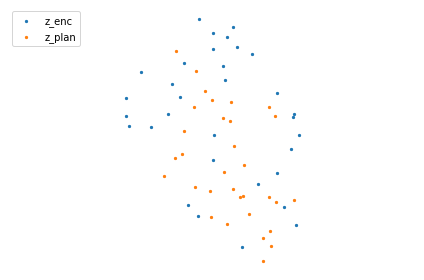

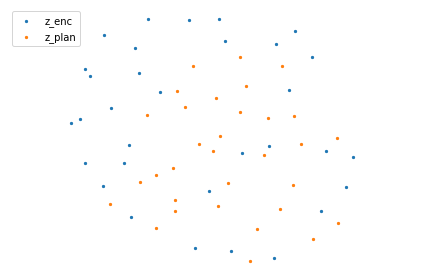

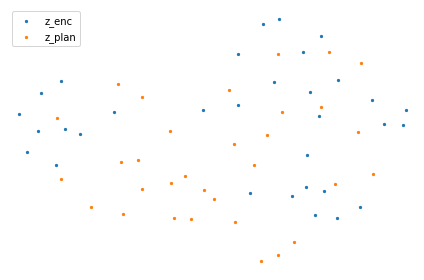

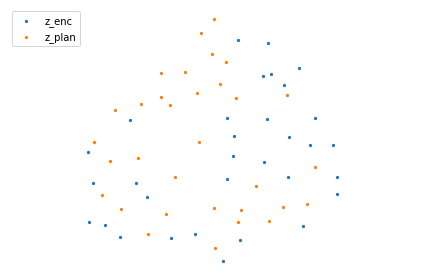

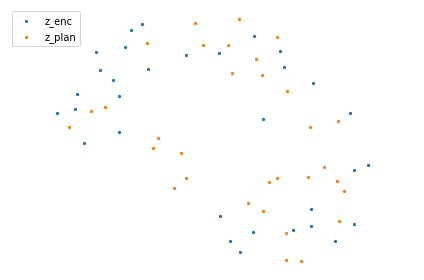

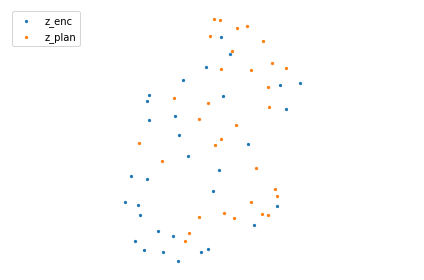

In [94]:
while t < TRAIN_STEPS:
    start_time = time.time()
    beta = beta_sched.scheduler(t)
    x = next(train_dist_dataset)
    total_train_loss = distributed_train_step(x, beta, prev_grad_norm)
    
    if t % valid_inc == 0:  
        valid_x = next(valid_dist_dataset)
        if config['gcbc']:
          total_val_loss = distributed_test_step(valid_x, beta)
        else:
          total_val_loss, ze, zp = distributed_test_step(valid_x, beta)

        # validation plotting
        progbar.add(valid_inc, [('Train Loss', train_loss.result()), ('Validation Loss', valid_loss.result()), ('Time (s)', round(time.time() - start_time, 1))])


        wandb.log({'train_loss_result':log(train_loss),
                    'valid_loss_result':log(valid_loss),
                    'valid_position_loss_result':log(valid_position_loss),
                    'valid_max_position_loss_result':log(valid_max_position_loss),
                    'valid_rotation_loss_result':log(valid_rotation_loss),
                    'valid_max_rotation_loss_result':log(valid_max_rotation_loss),
                    'valid_gripper_loss_result':log(valid_gripper_loss),
                    'actor_grad_norm': log(actor_grad_norm),
                    'actor_grad_norm_clipped': log(actor_grad_norm_clipped),
                  },
                  step=t)
          
        if not config['gcbc']:
          wandb.log({
                      'train_act_with_enc_loss_result':log(train_act_with_enc_loss),
                      'train_act_with_plan_loss_result':log(train_act_with_plan_loss),
                      'train_reg_loss_result':log(train_reg_loss),
                      'valid_act_with_enc_loss_result':log(valid_act_with_enc_loss),
                      'valid_act_with_plan_loss_result':valid_act_with_plan_loss.result(),
                      'valid_reg_loss_result':log(valid_reg_loss),
                      'beta_result':beta,
                      'encoder_grad_norm': log(encoder_grad_norm),
                      'planner_grad_norm': log(planner_grad_norm),
                      'encoder_grad_norm_clipped': log(encoder_grad_norm_clipped),
                      'planner_grad_norm_clipped': log(planner_grad_norm_clipped),
                    },
                    step=t)
          

        prev_grad_norm = log(global_grad_norm)
          
    if t % save_inc == 0:
        save_weights(model_path, actor, config, dl, run_id,optimizer, encoder, planner)
        if not config['gcbc']:
          z_enc, z_plan = produce_cluster_fig(next(v_it), encoder, planner, TEST_DATA_PATHS[0], num_take=dl.batch_size)
          wandb.log({'z_enc':z_enc, 'z_plan':z_plan}, step=t)
          latent_fig = project_enc_and_plan(ze, zp)
          #latent_img = plot_to_image(latent_fig)

    t += 1

In [95]:
# Use if deving locally - relatively painless
% cd lfp
! git pull
% cd ..

/content/learning_from_play/lfp
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 14 (delta 11), reused 8 (delta 5), pack-reused 0
Unpacking objects: 100% (14/14), done.
From https://github.com/sholtodouglas/learning_from_play
   9d3444b..1459601  master     -> origin/master
Updating 555d326..1459601
error: Your local changes to the following files would be overwritten by merge:
	lfp/utils.py
Please commit your changes or stash them before you merge.
Aborting
/content/learning_from_play
